In [80]:
from typing import List, Dict
from tqdm import tqdm
from tools.analysis_utils import (
    import_known_tokens,
    compile_scores,
    convert_raw,
    vjui
)
KNOWN_TOKENS, KNOWN_LEMMAS = import_known_tokens()
import regex
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

re_is_greek  = regex.compile("^\p{Greek}+$")
SPLIT_EVENLY = False  # Applies evenly split

# Analyse sur le hors domaine Priapées

## Objectifs

Évaluer et visualiser les résultats sur la vulgate

## Chargement du corpus GOLD

In [2]:
import lxml.etree as ET

GOLD: List[List[Dict[str, str]]] = [[]]
    
MILESTONES: List[int] = []
    
PRIA_START, PRIA_END = 0, 75
NS = {"t":"http://www.tei-c.org/ns/1.0"}

with open("../../../priapea-lemmat/priapea.xml") as f:
    xml = ET.parse(f)
    for ab_num, ab in enumerate(xml.xpath(
        "//t:ab", 
        namespaces=NS)):
        
        if ab_num < PRIA_START or ab_num > PRIA_END:
            continue
        
        for tok in ab.xpath("./t:w", namespaces=NS):
            token = tok.text
            try:
                lemma, pos, msd = (
                    tok.attrib["lemma"],
                    tok.attrib["pos"], 
                    tok.attrib["msd"]
                )
            except KeyError:
                print(ET.tostring(tok))
                raise
            if pos == "PUNC":
                if token in ".!?":
                    GOLD.append([])
                continue
            if re_is_greek.match(token):
                continue
            GOLD[-1].append({
                "form": token,
                "lemma": lemma,
                "pos": pos,
                "morph": msd
            })
            
        MILESTONES.append(sum(len([x for x in g if not x["form"].startswith("-")]) for g in GOLD if len(g)))


GOLD = [g for g in GOLD if len(g)]

if SPLIT_EVENLY:
    MILESTONES = [0]
    nb_toks = 0
    for sent in GOLD:
        nb_toks += len([tok for tok in sent if not tok["form"].startswith("-")])
        if nb_toks > 500:
            MILESTONES.append(MILESTONES[-1]  + nb_toks)
            nb_toks = 0
    if nb_toks > 0:
        MILESTONES.append(MILESTONES[-1] + nb_toks)
    MILESTONES = MILESTONES[1:]

In [3]:
#Debug:
print(MILESTONES)
print(len(MILESTONES))

[50, 105, 173, 192, 218, 249, 263, 287, 384, 424, 448, 522, 532, 587, 624, 670, 686, 700, 729, 766, 790, 804, 831, 855, 891, 945, 981, 1007, 1034, 1063, 1088, 1153, 1192, 1217, 1241, 1299, 1369, 1395, 1434, 1459, 1477, 1502, 1531, 1551, 1587, 1631, 1660, 1689, 1711, 1745, 1894, 1953, 1991, 2004, 2042, 2073, 2115, 2134, 2144, 2156, 2224, 2234, 2329, 2343, 2369, 2389, 2417, 2653, 2676, 2738, 2750, 2773, 2800, 2812, 2893, 2982]
76


### Export for training

In [4]:
import regex as re

matcher = re.compile(r"([a-zA-Z]+)(\d+)?(界\w+)?")

TASKS = "Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")

header = ["token", "Dis", "lemma"] + TASKS
with open("../../../priapea-lemmat/trainable-priapea.tsv", "w") as f:
    f.write("\t".join(header)+"\n")
    for sentence in convert_raw(
        GOLD, 
        task_list=["lemma"] + TASKS, 
        lemma_fn=vjui, form_fn=vjui, pos_fn=lambda x: x,
        pos_key="pos", clitics_are_duplicate=False, clitics_starts_with_dash=True,
        remove_disambiguation=False
    ):
        for tok in sentence:
            token, lemma, dis = tok["form"], "_", tok["lemma"]
            try:
                lemma_start, dis, lemma_end = matcher.findall(tok["lemma"])[0]
            except IndexError:
                if tok["form"] == "CD":
                    lemma = 3
            if not dis:
                dis = "_"
            lemma = lemma_start+lemma_end
            f.write("\t".join([token, dis, lemma] + [tok[task] for task in TASKS])+"\n")
        f.write("\n")
        
    

100%|██████████| 175/175 [00:00<00:00, 15885.11it/s]


## Reparse morphology for evaluation

In [5]:
TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")
PLATINUM = convert_raw(
    GOLD, 
    task_list=TASKS, 
    lemma_fn=vjui, form_fn=vjui,
    pos_key="pos", clitics_are_duplicate=False, clitics_starts_with_dash=True
)

100%|██████████| 175/175 [00:00<00:00, 12832.90it/s]


In [6]:
print(PLATINUM[0])

[{'lemma': 'carmen', 'Deg': '_', 'Numb': 'Sing', 'Person': '_', 'Mood_Tense_Voice': '_', 'Case': 'Gen', 'Gend': '_', 'pos': 'NOM', 'form': 'Carminis'}, {'lemma': 'incomptus', 'Deg': 'Pos', 'Numb': 'Sing', 'Person': '_', 'Mood_Tense_Voice': '_', 'Case': 'Gen', 'Gend': 'MascNeut', 'pos': 'ADJqua', 'form': 'incompti'}, {'lemma': 'lusus', 'Deg': '_', 'Numb': 'Sing', 'Person': '_', 'Mood_Tense_Voice': '_', 'Case': 'Acc', 'Gend': '_', 'pos': 'NOM', 'form': 'lusus'}, {'lemma': 'lego', 'Deg': '_', 'Numb': 'Sing', 'Person': '_', 'Mood_Tense_Voice': 'Par|Fut|Act', 'Case': 'Voc', 'Gend': 'Masc', 'pos': 'VER', 'form': 'lecture', 'Mood': 'Par', 'Tense': 'Fut', 'Voice': 'Act'}, {'lemma': 'procax', 'Deg': 'Pos', 'Numb': 'Plur', 'Person': '_', 'Mood_Tense_Voice': '_', 'Case': 'Acc', 'Gend': 'MascFem', 'pos': 'ADJqua', 'form': 'procaces'}, {'lemma': 'conueniens', 'Deg': 'Pos', 'Numb': 'Sing', 'Person': '_', 'Mood_Tense_Voice': '_', 'Case': 'Acc', 'Gend': 'Neut', 'pos': 'ADJqua', 'form': 'conueniens'}, 

## Obtention des données (formes uniquement)

In [7]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in PLATINUM
]
nb = 0
for sent in TOKENS:
    nb += len(sent)

## Test

In [8]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 128


OUTPUT = []
MODEL_PATH = "../../../pie/models/FinalModelVulgate-lemma-2020_10_14-18_09_35.tar"
MODEL_PATH = "../../../latin-lasla-models/model.tar"

tagger = Tagger(device="cpu", batch_size=100, lower=False, tokenize=False)
tagger.add_model(MODEL_PATH, *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])

2it [00:03,  1.52s/it]


## Evaluation

In [9]:
RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT, PLATINUM, task_list=TASKS, known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS,
    lower_tokens=False, lower_lemma=False
)

In [83]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

data = [["Task", "Accuracy", "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.3f}".format(accuracy_score(truth, pred)),
        "{0:.3f}".format(accuracy_score(pred_limited, truth_limited))
    ])
print(tabulate(data))

print(DataFrame(data).to_latex())

----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.942     0.942
Deg               0.968     0.903
Numb              0.947     0.941
Person            0.990     0.960
Mood_Tense_Voice  0.961     0.870
Case              0.894     0.841
Gend              0.917     0.778
pos               0.950     0.950
----------------  --------  ------------------
\begin{tabular}{llll}
\toprule
{} &                 0 &         1 &                   2 \\
\midrule
0 &              Task &  Accuracy &  Accuracy on V != \_ \\
1 &             lemma &     0.942 &               0.942 \\
2 &               Deg &     0.968 &               0.903 \\
3 &              Numb &     0.947 &               0.941 \\
4 &            Person &     0.990 &               0.960 \\
5 &  Mood\_Tense\_Voice &     0.961 &               0.870 \\
6 &              Case &     0.894 &               0.841 \\
7 &              Gend &     0.917 &               0.778 \\
8 &         

```
----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.92      0.92
Deg               0.96      0.90
Numb              0.94      0.94
Person            0.99      0.97
Mood_Tense_Voice  0.96      0.87
Case              0.88      0.81
Gend              0.92      0.81
pos               0.93      0.93
----------------  --------  ------------------
```

### Matrice de confusion lemmes

In [11]:
with open("1.4.X-Priapees-Lemma-Confusion.tsv", "w") as f:
    f.write("lemma\tprediction\ttoken\tnumber\n")
    for lemma in ERRORS["lemma"]:
        for pred in ERRORS["lemma"][lemma]:
            for token, count in ERRORS["lemma"][lemma][pred].items():
                f.write(f"{lemma}\t{pred}\t{token}\t{count}\n")

### Visualisation sur le corpus

#### Accuracy par Priapées

In [36]:
from math import ceil
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Compute the accuracy on splits
        
SPLITS_TASK = {
    task: []
    for task in RAW_SCORES
}
SPLITS_TASK["size"] = []
DIVIDE_BY = round(sum([len(x) for x in GOLD]) / 20) # 5%

lengths = []
support_done = False
for task, (pred, truth) in RAW_SCORES.items():
    ms_start = 0
    for milestone in MILESTONES:
        SPLITS_TASK[task].append(accuracy_score(truth[ms_start:milestone], pred[ms_start:milestone]))
        length = milestone - ms_start + 1
        if not support_done:
            SPLITS_TASK["size"].append(length)
        ms_start = milestone
    support_done = True
        

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  lemma &   Deg &  Numb &  Person &  Mood\_Tense\_Voice &  Case &  Gend &   pos &  size \\
\midrule
1  &  0.920 & 0.980 & 0.940 &   0.980 &             0.940 & 0.860 & 0.860 & 0.920 &    51 \\
2  &  0.964 & 1.000 & 0.964 &   1.000 &             0.964 & 0.945 & 0.891 & 1.000 &    56 \\
3  &  0.956 & 0.971 & 0.941 &   1.000 &             1.000 & 0.897 & 0.868 & 0.941 &    69 \\
4  &  0.947 & 1.000 & 1.000 &   1.000 &             1.000 & 0.789 & 1.000 & 1.000 &    20 \\
5  &  0.885 & 1.000 & 0.962 &   1.000 &             0.962 & 0.846 & 0.923 & 1.000 &    27 \\
6  &  0.935 & 1.000 & 0.968 &   1.000 &             1.000 & 0.903 & 0.935 & 1.000 &    32 \\
7  &  0.929 & 1.000 & 0.929 &   0.929 &             0.929 & 0.857 & 1.000 & 0.929 &    15 \\
8  &  0.958 & 1.000 & 0.792 &   1.000 &             1.000 & 0.875 & 1.000 & 0.958 &    25 \\
9  &  0.969 & 0.979 & 0.969 &   1.000 &             1.000 & 0.928 & 0.938 & 0.969 &    98 \\
10 &  1.000 & 0.975 & 

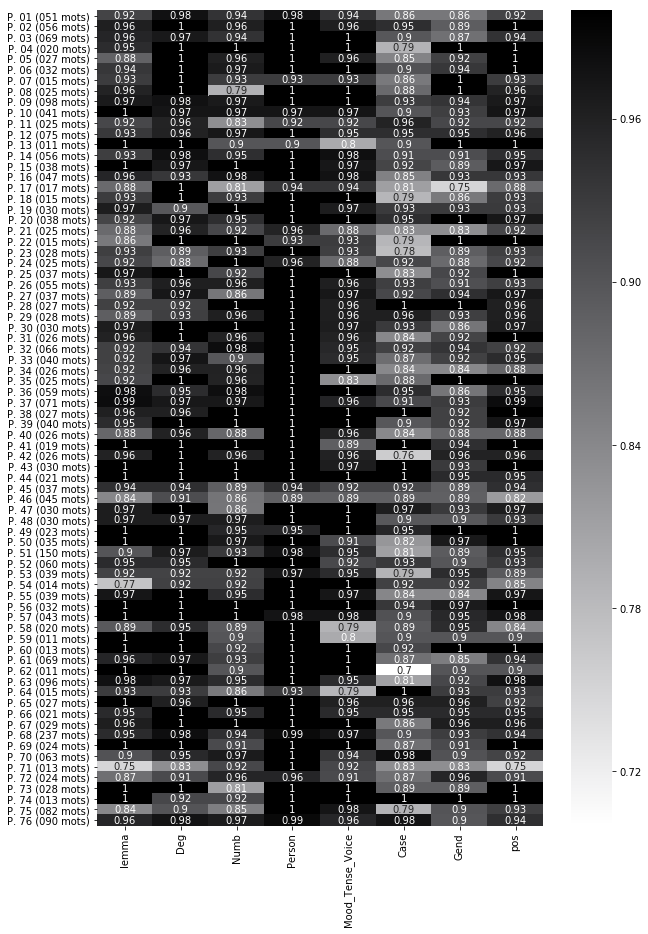

In [89]:
if SPLIT_EVENLY:
    indexes = [
        f"Corpus {ind+1} ({e - s} mots)"
        for ind, (s, e) in enumerate(zip([0] + MILESTONES[:-1], MILESTONES))
    ]
    figsize = 10, 10
    #del SPLITS_TASK["size"]
else:
    indexes = [
            "P. {:02d} ({:03d} mots)".format(idx, size)
        for idx, size in zip(list(range(PRIA_START+1, PRIA_END+2)), SPLITS_TASK["size"])
    ]
    
    #del SPLITS_TASK["size"]
    figsize = 10, 15
    DF_PRIAPEES = DataFrame(SPLITS_TASK, index=list(range(PRIA_START+1, PRIA_END+2)))
    print(DF_PRIAPEES.to_latex(float_format="{:0.3f}".format))
    
DF_PRIAPEES = DataFrame(SPLITS_TASK, index=indexes)
#if not SPLIT_EVENLY:
#    DF_PRIAPEES["size"] = DF_PRIAPEES["size"] / sum(DF_PRIAPEES["size"])

plt.figure(figsize=figsize)
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(DF_PRIAPEES.loc[:, DF_PRIAPEES.columns != 'size'], annot=True, cmap=cmap)


(30.0,
 40.23684210526316,
 68,
 24.0,
 11,
                   lemma  Deg  Numb  Person  Mood_Tense_Voice  Case  Gend  pos  \
 P. 13 (011 mots)    0.0  0.0   1.1     1.1               2.2   1.1   0.0  0.0   
 P. 59 (011 mots)    0.0  0.0   1.1     0.0               2.2   1.1   1.1  1.1   
 P. 62 (011 mots)    0.0  0.0   1.1     0.0               0.0   3.3   1.1  1.1   
 
                   size  
 P. 13 (011 mots)    11  
 P. 59 (011 mots)    11  
 P. 62 (011 mots)    11  ,
 237,
                       lemma       Deg       Numb    Person  Mood_Tense_Voice  \
 P. 68 (237 mots)  12.050847  4.016949  13.055085  3.012712          6.025424   
 
                        Case       Gend        pos  size  
 P. 68 (237 mots)  24.101695  17.072034  14.059322   237  )

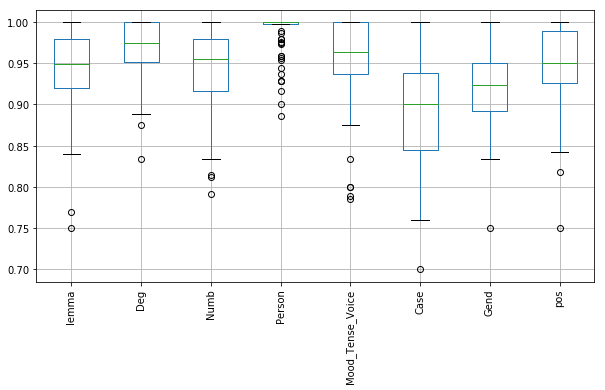

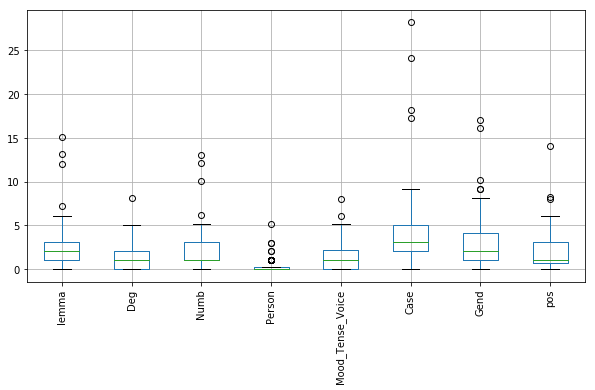

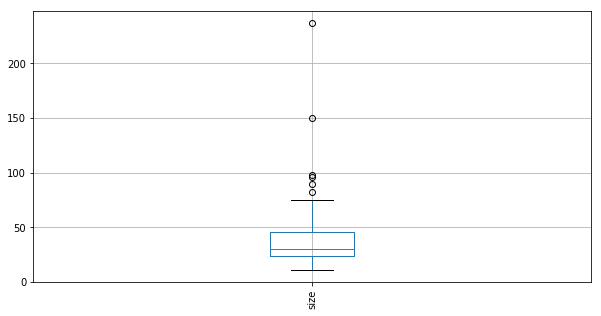

In [79]:
DF_ABSOLUTE = DF_PRIAPEES.copy()
for column in DF_PRIAPEES.columns:
    if column != "size":
        DF_ABSOLUTE[column] = (1 - DF_ABSOLUTE[column]) * DF_ABSOLUTE["size"]
        
fig, ax = plt.subplots(figsize=(10,5))
DF_PRIAPEES.loc[:, DF_PRIAPEES.columns != 'size'].boxplot(rot=90, ax=ax)

fig, ax = plt.subplots(figsize=(10,5))
DF_ABSOLUTE.loc[:, DF_PRIAPEES.columns != 'size'].boxplot(rot=90, ax=ax)

fig, ax = plt.subplots(figsize=(10,5))
DF_ABSOLUTE.loc[:, DF_PRIAPEES.columns == "size"].boxplot(rot=90, ax=ax)
(
    DF_ABSOLUTE["size"].median(), 
    DF_ABSOLUTE["size"].mean(),
    (DF_ABSOLUTE["size"] < 70).tolist().count(True),
    DF_ABSOLUTE["size"].quantile(0.25),
    DF_ABSOLUTE["size"].min(),
    DF_ABSOLUTE[(DF_ABSOLUTE["size"] < 12)],
    DF_ABSOLUTE["size"].max(),
    DF_ABSOLUTE[DF_ABSOLUTE["size"] == 237]
)

### Impact sur le corpus en fonction de la POS

100%|██████████| 175/175 [00:00<00:00, 16935.54it/s]

[50, 105, 173, 192, 218, 249, 263, 287, 384, 424, 448, 522, 532, 587, 624, 670, 686, 700, 729, 766, 790, 804, 831, 855, 891, 945, 981, 1007, 1034, 1063, 1088, 1153, 1192, 1217, 1241, 1299, 1369, 1395, 1434, 1459, 1477, 1502, 1531, 1551, 1587, 1631, 1660, 1689, 1711, 1745, 1894, 1953, 1991, 2004, 2042, 2073, 2115, 2134, 2144, 2156, 2224, 2234, 2329, 2343, 2369, 2389, 2417, 2653, 2676, 2738, 2750, 2773, 2800, 2812, 2893, 2982]



/home/thibault/dev/these/these_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


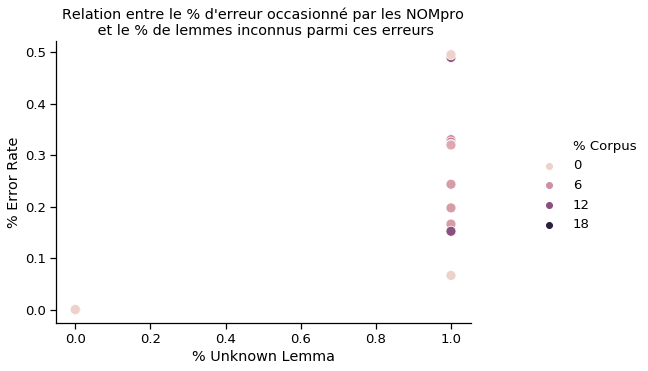

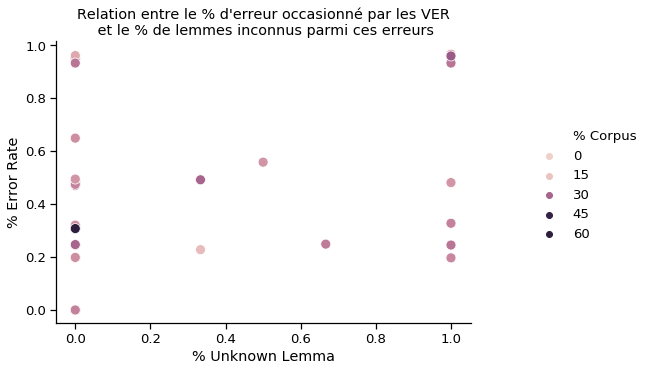

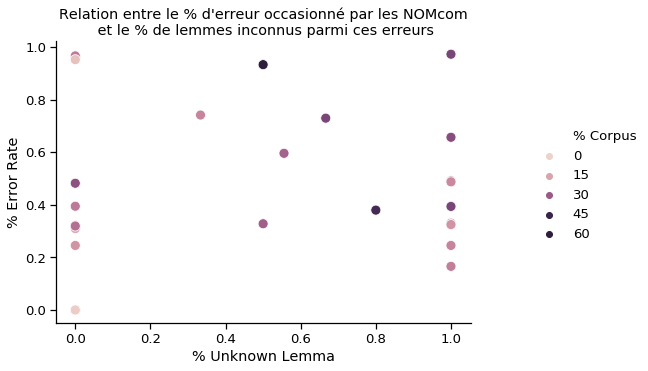

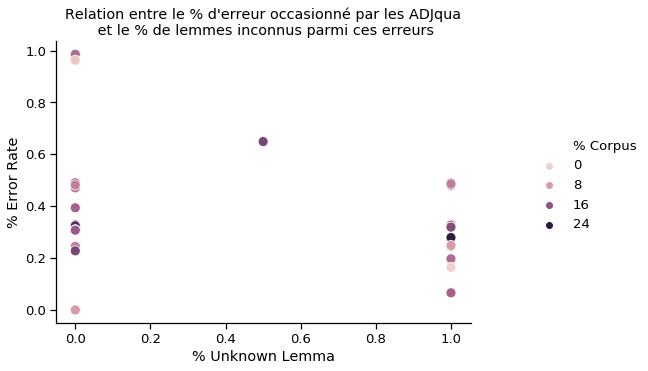

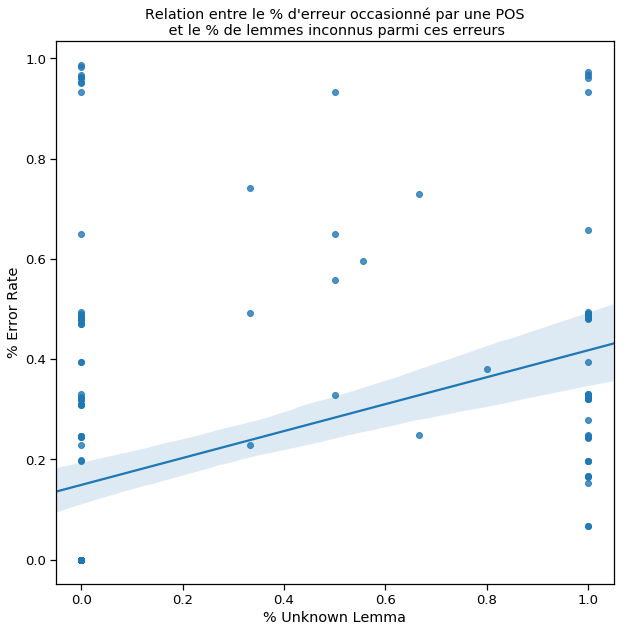

In [19]:
from collections import defaultdict, namedtuple


def compute_accuracy(trues, corpus_size, corpus_accuracy) -> int:
    return ((len(trues) - sum(trues)) / corpus_size) / corpus_accuracy

    
def compute_rate_unknown(score, key):
    if score[key]:
        return 1 - sum(score[key]) / len(score[key])
    return 0

def get_sizes_from_milestones(milestones: List[int], full_size: int) -> List[int]:
    x = []
    for ms_start, ms_end in zip([0] + milestones, milestones + [full_size]):
        x.append(ms_end - ms_start + 1)  # Because index starts at 0
    return x


TextInformation = namedtuple("TextInformation", ["title", "size", "error_rate"])

print(MILESTONES)

# Récupération des données avec POS "Classiques"
PLATINUM_NomCom = convert_raw(
    GOLD, 
    task_list=TASKS, 
    lemma_fn=vjui, form_fn=vjui, pos_fn=lambda x: x,
    pos_key="pos", clitics_are_duplicate=False, clitics_starts_with_dash=True
)

RESULTS_Pro, RAW_SCORES_Pro, _, _, SCORES_KNOWN_Pro = compile_scores(
    OUTPUT, PLATINUM_NomCom, task_list=TASKS, known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS,
    lower_tokens=False, lower_lemma=False
)
SIZES = get_sizes_from_milestones(MILESTONES, len(SCORES_KNOWN_Pro))

if SPLIT_EVENLY:
    TextTitleSize = [
        TextInformation(f"Corpus {tid+1}", length, 1-accuracy) 
        for tid, length, accuracy in zip(
             range(len(SIZES)), SIZES, SPLITS_TASK["lemma"]
        )
    ]
else:
    TextTitleSize = [
        TextInformation(tid, length, 1-accuracy) 
        for tid, length, accuracy in zip(
             range(PRIA_START+1, PRIA_END+2), SIZES, SPLITS_TASK["lemma"]
        )
    ]
# Compile data to take into account LEMMA and POS

LIMIT_TO_POS = {"VER", "NOMcom", "NOMpro", "ADJqua"}
LemmaPosUnknown = defaultdict(lambda :defaultdict(lambda: defaultdict(list)))
start = 0


for text_id, end in enumerate(MILESTONES):
    for token in SCORES_KNOWN_Pro[start:end]:
        LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["Accuracy"].append(int(token["lemma"]))
        
        if not token["lemma"]:  # If lemmatization is wrong
            LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["KnownTokens"].append(
                int(token["known_token"])
            )
            LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["KnownLemmas"].append(
                int(token["known_lemma"])
            )
    start = end

LemmaPosUnknownDataFrame = DataFrame([
    {
        "POS": pos,
        "% Error Rate": compute_accuracy(
            score["Accuracy"],
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        ),
        "% Unknown Tokens": compute_rate_unknown(score, "KnownTokens"),
        "% Unknown Lemma": compute_rate_unknown(score, "KnownLemmas"),
        "% Corpus": round(100*len(score["Accuracy"])/TextTitleSize[text_id].size)
    }
    for text_id, text_values in LemmaPosUnknown.items()
    for pos, score in text_values.items()
    if pos in LIMIT_TO_POS
])

for pos in LIMIT_TO_POS:
    with sns.plotting_context("notebook", font_scale=1.2):
        g = sns.relplot(
            x="% Unknown Lemma", y="% Error Rate",#, style="POS", 
            hue="% Corpus", s=100,
            data=LemmaPosUnknownDataFrame[LemmaPosUnknownDataFrame.POS == pos], 
            cmap=sns.husl_palette(len(LIMIT_TO_POS))
        )
        g.fig.set_size_inches(10,5)
        g.fig.axes[0].set_title(f"Relation entre le % d'erreur occasionné par les {pos}"
                                "\n et le % de lemmes inconnus parmi ces erreurs")
        g.fig.show()
        
with sns.plotting_context("notebook", font_scale=1.2):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.regplot(
        x="% Unknown Lemma", y="% Error Rate",
        data=LemmaPosUnknownDataFrame,
        ax=ax
    )
    ax.set_title("Relation entre le % d'erreur occasionné par une POS"
                            "\n et le % de lemmes inconnus parmi ces erreurs")
    fig.show()

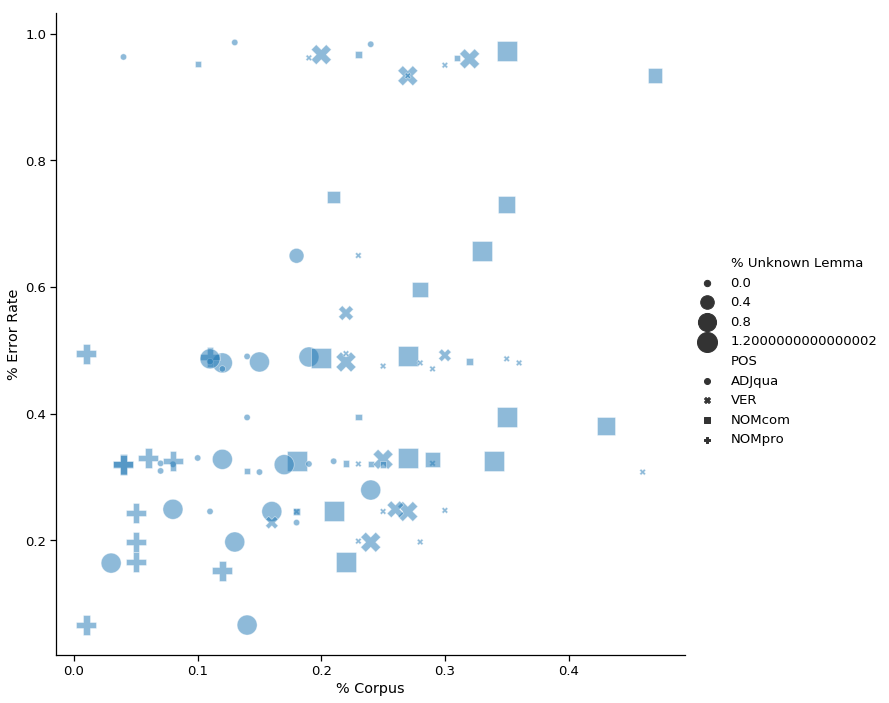

In [20]:
LemmaPosUnknownDataFrame["% Corpus"] = LemmaPosUnknownDataFrame["% Corpus"] / 100
with sns.plotting_context("notebook", font_scale=1.2):
    sns.relplot(x="% Corpus", y="% Error Rate", style="POS", 
                size="% Unknown Lemma",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=10,
                data=LemmaPosUnknownDataFrame[LemmaPosUnknownDataFrame["% Error Rate"] > 0]
               )

### Visualiser par catégorie la relation % des erreurs / % du corpus (sans distinction des textes)

## Analyse des Priapées en dessous de X %

In [21]:
from IPython.core.display import display, HTML

THRESHOLD = 1.0

TO_CHECK = [
    pria_id - PRIA_START - 1
    for pria_id in (DF_PRIAPEES["lemma"].loc[DF_PRIAPEES["lemma"] < THRESHOLD]).index
]
TO_CHECK_ID = list((DF_PRIAPEES["lemma"].loc[DF_PRIAPEES["lemma"] < THRESHOLD]).index)
    
pred, truth = RAW_SCORES["lemma"]
flatten_tokens = [tok for sent in TOKENS for tok in sent]
ms_start = 0

for pria_id, (ms_start, ms_end) in enumerate(zip([0] + MILESTONES, MILESTONES)):
    #if ms_end is not None:
    #    ms_end += 1
    if pria_id not in TO_CHECK:
        continue
    nice_id = TO_CHECK_ID.pop(0)
    text = []
    nb_tokens = ms_end - ms_start
    size = 1 / nb_tokens
    nb_errors = 0
    for tok, t, p in zip(flatten_tokens[ms_start:ms_end], truth[ms_start:ms_end], pred[ms_start:ms_end]):
        if t == p:
            text.append(tok)
        else:
            text.append(f"<span style='color: red;'>{tok}[<span style='color:green;'>{t}</span>,{p}]</span>")
            nb_errors += 1
            
    text = "<p>"+" ".join(text).replace(" -", "-") + "</p>"
    text = f"""<h2>Priapée {nice_id}</h2>
    <p>
        <small>
        <b>Accuracy:</b> {accuracy_score(truth[ms_start:ms_end], pred[ms_start:ms_end]):.3f} <br />
        <b>Tokens:</b> {ms_end - ms_start}<br />
        <b>Errors: </b> {nb_errors}<br />
        <b>1 error =</b> -{size*100:.1f} % drop in accuracy <br />
        <span style='color:green;'>Ground Truth</span> - <span style='color:red;'>Prediction</span>
        </small>
    </p>
    <p>{text}</p>
    """
    display(HTML(text))
    

TypeError: unsupported operand type(s) for -: 'str' and 'int'